## 問題点の整理と解決

In [2]:
from scipy.optimize import fmin
import numpy as np
from time import time
import matplotlib.pyplot as plt

前回の勉強会で検討したコードだと、貯蓄がマイナスになる可能性や消費が非正になる可能性を排除できていなかったので修正する。

In [3]:
# 一つの評価点におけるresidualを計算する関数を定義する
def calc_residual(
    w: float, theta0: float, theta1: float, r: float, beta: float, gamma: float
) -> float:
    a = theta0 + theta1 * w

    """
    モデルの設定上、貯蓄aは必ず正である必要がある。
    しかし、theta0とtheta1の値によってはaが負になるので、それを避けるためにペナルティとしてresidualが大きくなるように設定する。
    なお、ペナルティの値をinfにすると後のfmin関数でエラーが出るので、有限の大きな値に留めておく。
    """
    if a < 0:
        return 10**5
    else:
        """
        消費が非正になることをを避けるためにペナルティとしてresidualが大きくなるように設定する。
        """    
        if w - a > 0:
            residual = (beta*(1+r))*((((1+r)*a)**(-gamma))/((w-a)**(-gamma)))-1
            return residual
        else:
            return 10**5
    


In [4]:
# 全ての評価点におけるresidualをまとめてMSEを計算する関数を定義する
def gen_ssr_func(w_list, r, beta, gamma):
    def calc_ssr(theta) -> float:
        theta0, theta1 = theta
        ssr = 0.0
        for w in w_list:
            try:
                ssr += calc_residual(w, theta0, theta1, r, beta, gamma) ** 2
            except ValueError:  # as e:
                # print(e)
                continue
        return ssr

    return calc_ssr

In [5]:
# メインパート：MSEを最小化して政策関数の切片と傾きのパラメータを求める
def main():

    # 状態変数 w のグリッドを生成する
    w_list = np.linspace(0.1, 1.0, 25)

    # カリブレーション
    beta = 0.985**30
    r = 1.025**30 - 1.0
    gamma: float = 2.0


    # theta0, theta1 をインプットにMSEを計算する関数をつくる
    calc_ssr = gen_ssr_func(w_list, r, beta, gamma)

    try:
        # fminで最適な theta0, theta1 を探す
        result = fmin(calc_ssr, x0=[0.3, 0.3], maxiter=2000, ftol=1e-10)
        return result
    except Exception:
        import traceback

        with open("error.log", "a") as f:
            traceback.print_exc(file=f)



In [6]:
# 実行
t0 = time()
pf = main()
t1 = time()
print(f"Computed policy function = \n\n{pf}\n\nin {t1 - t0} seconds.")


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 93
Computed policy function = 

[-8.05203663e-08  3.55009365e-01]

in 0.03962516784667969 seconds.


なお、切片と傾きの初期値を大きくすると…

In [7]:
# 状態変数 w のグリッドを生成する
w_list = np.linspace(0.1, 1.0, 25)

# カリブレーション
beta = 0.985**30
r = 1.025**30 - 1.0
gamma: float = 2.0


# theta0, theta1 をインプットに残差2乗和を計算する関数を定義
calc_ssr = gen_ssr_func(w_list, r, beta, gamma)

fmin(calc_ssr, x0=[0.5, 0.75], maxiter=2000, ftol=1e-10)

Optimization terminated successfully.
         Current function value: 250000000000.000000
         Iterations: 10
         Function evaluations: 39


array([0.5 , 0.75])

正しく最適化されない！

これはおそらく、このような値の大きい初期値の周辺ではaがwと比べて大きすぎていつでも"消費が非正ならresidualは10^5"ルールに引っかかるため、**初期値周辺で目的関数の傾きが完全に0となってそこが極小点だと判定されてしまう**ことが原因かと思われる。

実際、theta0=0.7, theta1=0.75のケースとtheta0=0.701, theta1=0.75のケースにおけるMSEを比較してみると…

In [8]:
print(calc_ssr([0.7,0.75]))
print(calc_ssr([0.701,0.75]))

250000000000.0
250000000000.0


…どちらもまったく同じ！

解決策としては、たとえこのような（本当は最適な係数からは程遠いような）初期値から始めたときでも、少しパラメータの値を動かしたら目的関数の値が変わってくれる（＝目的関数の傾きが0とならない）ように設定すればよい。

In [9]:
# 一つの評価点におけるresidualを計算する関数を定義する（修正版）
def calc_residual_alt(
    w: float, theta0: float, theta1: float, r: float, beta: float, gamma: float
) -> float:
    a = theta0 + theta1 * w

    """
    モデルの設定上、貯蓄aは必ず正である必要がある。
    しかし、theta0とtheta1の値によってはaが負になるので、それを避けるためにペナルティとしてresidualが大きくなるように設定する。
    なお、ペナルティの値をinfにすると後のfmin関数でエラーが出るので、有限の大きな値に留めておく。
    """
    if a < 0:
        return 10**5
    else:
        """
        消費が非正になることを避けるためにペナルティをつける。
        ただし、今度はresidual自体にペナルティを設定するのではなく、一期の限界効用にペナルティを設定する。
        消費が非正のときには限界効用が非常に大きくなる（消費がほぼ0）というように設定。
        """    
        if w - a > 0:
            mu1 = (w-a)**(-gamma)
        else:
            mu1 = 10**10
        
        residual = (beta*(1+r))*((((1+r)*a)**(-gamma))/(mu1))-1
        return residual
    
# 全ての評価点におけるresidualをまとめてMSEを計算する関数を定義する（修正版）
def gen_ssr_func_alt(w_list, r, beta, gamma):
    def calc_ssr(theta) -> float:
        theta0, theta1 = theta
        ssr = 0.0
        for w in w_list:
            try:
                ssr += calc_residual_alt(w, theta0, theta1, r, beta, gamma) ** 2
            except ValueError:  # as e:
                # print(e)
                continue
        return ssr

    return calc_ssr

In [10]:
# 状態変数 w のグリッドを生成する
w_list = np.linspace(0.1, 1.0, 25)

# カリブレーション
beta = 0.985**30
r = 1.025**30 - 1.0
gamma: float = 2.0


# theta0, theta1 をインプットに残差2乗和を計算する関数を定義
calc_ssr = gen_ssr_func_alt(w_list, r, beta, gamma)

fmin(calc_ssr, x0=[0.7, 0.75], maxiter=2000, ftol=1e-10)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 138


array([-5.42447508e-08,  3.55009021e-01])

これなら、大きい初期値から始めてしまった場合でも正しく最適化されている。

In [11]:
print(calc_ssr([0.7,0.75]))
print(calc_ssr([0.701,0.75]))

24.999999998640604
24.99999999864332


実際、theta0=0.7, theta1=0.75のケースとtheta0=0.701, theta1=0.75のケースとで、ほんのわずかではあるがMSEの値が変わっている。


最適化アルゴリズムを回すときには、このほんのわずかの違いがとても重要だということ。

## leastsqを使う

今回のように評価点ごとのresidualの合計の仕方をMSEに設定する場合は、leastsq関数を使うともう少しスッキリ書ける。

leastsq関数は関数
\begin{align*}
F(x;\Theta) = \left[ f(x_1;\Theta), \cdots, f(x_N;\Theta)\right]'
\end{align*}
を設定すると、以下のような問題を解いてくれる。
\begin{align*}
 \min_{\Theta}\ \  \sum_{i=1}^N (f(x_i;\Theta))^2
\end{align*}

In [12]:
from scipy.optimize import leastsq
import numpy as np
from time import time

In [13]:
# すべての評価点におけるresidualを計算して箱に入れて出力する関数をつくる
def calc_residual(theta, w_list, r, beta, gamma):
    
    theta0, theta1 = theta
    resid_box = np.empty(len(w_list))
    
    for i in range(len(w_list)): 
    
        
        w = w_list[i]
        a = theta0 + theta1 * w

        """
        モデルの設定上、貯蓄aは必ず正である必要がある。
        しかし、theta0とtheta1の値によってはaが負になるので、それを避けるためにペナルティとしてresidualが大きくなるように設定する。
        なお、ペナルティの値をinfにすると後のfmin関数でエラーが出るので、有限の大きな値に留めておく。
        """
        if a < 0:
            resid_box[i] = 10**5

        else:
            """
            消費が非正になることを避けるためにペナルティをつける。
            ただし、今度はresidual自体にペナルティを設定するのではなく、一期の限界効用にペナルティを設定する。
            消費が非正のときには限界効用が非常に大きくなる（消費がほぼ0）というように設定。
            """    
            if w - a > 0:
                mu1 = (w-a)**(-gamma)
            else:
                mu1 = 10**5      
            
            residual = (beta*(1+r))*((((1+r)*a)**(-gamma))/(mu1))-1
            resid_box[i] = residual

    return resid_box
    

In [14]:
def main():

    # 状態変数 w のグリッドを生成する
    w_list = np.linspace(0.1, 1.0, 25)

    # カリブレーション
    beta = 0.985**30
    r = 1.025**30 - 1.0
    gamma: float = 2.0



    try:
        # leastsqで最適な theta0, theta1 を探す
        result = leastsq(calc_residual, x0=[0.7, 0.75], args=(w_list, r, beta, gamma))
        return result
    except Exception:
        import traceback

        with open("error.log", "a") as f:
            traceback.print_exc(file=f)

In [15]:
t0 = time()
pf = main()
t1 = time()
print(f"Computed policy function = \n\n{pf}\n\nin {t1 - t0} seconds.")

Computed policy function = 

(array([2.00549752e-10, 3.55008877e-01]), 2)

in 0.002263784408569336 seconds.


In [16]:
theta0_range = np.linspace(0.0, 1.0, 10)
theta1_range = np.linspace(-1.0, 1.0, 10)

In [17]:
# 3Dプロットのためのデータ作成
theta0_vals, theta1_vals = np.meshgrid(theta0_range, theta1_range)
ssr_vals = np.zeros_like(theta0_vals)

for i in range(theta0_vals.shape[0]):
    for j in range(theta0_vals.shape[1]):
        theta0 = theta0_vals[i, j]
        theta1 = theta1_vals[i, j]
        theta = [theta0, theta1]
        ssr_vals[i, j] = calc_ssr(theta)

/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_28595/1742608867.py:25: RuntimeWarning: divide by zero encountered in scalar power
  residual = (beta*(1+r))*((((1+r)*a)**(-gamma))/(mu1))-1


/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_28595/1199220139.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


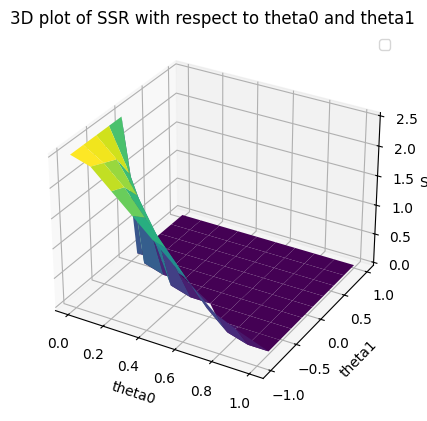

In [19]:
# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(theta0_vals, theta1_vals, ssr_vals, cmap="viridis")


ax.set_xlabel("theta0")
ax.set_ylabel("theta1")
ax.set_zlabel("SSR")
ax.set_title("3D plot of SSR with respect to theta0 and theta1")
ax.legend()

plt.show()